# DSC530 Week5 Exercises

Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [3]:
import numpy as np

import thinkstats2
import thinkplot

## Exercise 5-1

In the BRFSS (see Section 5.4), the distribution of heights is roughly normal with parameters µ = 178 cm and σ = 7.7 cm for men, and µ = 163 cm and σ = 7.3 cm for women.

In order to join Blue Man Group, you have to be male between 5’10” and 6’1” (see http://bluemancasting.com). What percentage of the U.S. male population is in this range? Hint: use `scipy.stats.norm.cdf`.

`scipy.stats` contains objects that represent analytic distributions

In [6]:
import scipy.stats

For example <tt>scipy.stats.norm</tt> represents a normal distribution.

In [8]:
mu = 178
sigma = 7.7
dist = scipy.stats.norm(loc=mu, scale=sigma)
type(dist)

scipy.stats._distn_infrastructure.rv_continuous_frozen

A "frozen random variable" can compute its mean and standard deviation.

In [10]:
dist.mean(), dist.std()

(178.0, 7.7)

It can also evaluate its CDF.  How many people are below the mean by more than one standard deviation?  About 16%

In [12]:
dist.cdf(mu - sigma)

0.1586552539314574

How many people are between 5'10" and 6'1"?

In [14]:
# Since 5'10" is 177.8 cm and 6'1" is 185.42 cm according to Google search, we find the diff of the cdf values of the 2 parameters
dist.cdf(185.42) - dist.cdf(177.8)

0.3427468376314737

## Exercise 5-2
To get a feel for the Pareto distribution, let’s see how different the world would be if the distribution of human height were Pareto. With the parameters xm = 1 m and α = 1.7, we get a distribution with a reasonable minimum, 1 m, and median, 1.5 m.

Plot this distribution. What is the mean human height in Pareto world? What fraction of the population is shorter than the mean? If there are 7 billion people in Pareto world, how many do we expect to be taller than 1 km? How tall do we expect the tallest person to be?

`scipy.stats.pareto` represents a pareto distribution.  In Pareto world, the distribution of human heights has parameters alpha=1.7 and xmin=1 meter.  So the shortest person is 100 cm and the median is 150.

In [16]:
alpha = 1.7
xmin = 1  # meter
dist = scipy.stats.pareto(b=alpha, scale=xmin)
dist.median()

1.5034066538560549

What is the mean height in Pareto world?

In [18]:
dist.mean()

2.428571428571429

What fraction of people are shorter than the mean?

In [20]:
dist.cdf(dist.mean())

0.778739697565288

Out of 7 billion people, how many do we expect to be taller than 1 km?  You could use <tt>dist.cdf</tt> or <tt>dist.sf</tt>.

In [22]:
# Use the 1 - the cdf of 1000 meters to get the fraction of people taller than 1000 m, and times the 7 billion people to get the quantity
# Also, using the int function to truncate the number so the decimals are not included and person cannot be any fraction (so round func won't make 
# sense)
int((1 - dist.cdf(1000))*(7e9))

55602

How tall do we expect the tallest person to be?

In [24]:
# To find the tallest person, we would need to find the value when the related cdf = 1
# According to the CDF formula in the textbook on page 58, we can tell the CDF(x) = 1 - (x min / x)^ alpha. We need to find the x when CDF(x) = 1 or 
# very close = 1 when we know the population is 7 billion people. Deriving the formula:
# (x min / x)^ alpha = 1 - CDF(x)
# (x min)^ alpha / (x)^ alpha = 1 - CDF(x)
# (x min)^ alpha = (x)^ alpha - CDF(x) * (x)^ alpha
# (x min)^ alpha = (x)^ alpha * [1 - CDF(x)]
# (x)^ alpha = (x min)^ alpha / [1 - CDF(x)]
# x = x min / [1 - CDF(x)]^ (1/alpha)
# To make CDF(x) close = 1, we can set CDF(x) = 1 - (1/n) where n = 7 billion.
# As a result, x =  x min / [1 - (1 - 1/n)]^ (1/alpha)

tallest = xmin / ((1- (1-(1/7e9)))**(1/alpha)) 
tallest

618349.6106759505

## Exercise 6-1
The distribution of income is famously skewed to the right. In this exercise, we’ll measure how strong that skew is.
The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables. Data collected in 2013 is available from http://www.census.gov/hhes/www/cpstables/032013/hhinc/toc.htm. I downloaded `hinc06.xls`, which is an Excel spreadsheet with information about household income, and converted it to `hinc06.csv`, a CSV file you will find in the repository for this book. You will also find `hinc2.py`, which reads this file and transforms the data.

The dataset is in the form of a series of income ranges and the number of respondents who fell in each range. The lowest range includes respondents who reported annual household income "Under \\$5000." The highest range includes respondents who made "\\$250,000 or more."

To estimate mean and other statistics from these data, we have to make some assumptions about the lower and upper bounds, and how the values are distributed in each range. `hinc2.py` provides `InterpolateSample`, which shows one way to model this data. It takes a `DataFrame` with a column, `income`, that contains the upper bound of each range, and `freq`, which contains the number of respondents in each frame.

It also takes `log_upper`, which is an assumed upper bound on the highest range, expressed in `log10` dollars. The default value, `log_upper=6.0` represents the assumption that the largest income among the respondents is $10^6$, or one million dollars.

`InterpolateSample` generates a pseudo-sample; that is, a sample of household incomes that yields the same number of respondents in each range as the actual data. It assumes that incomes in each range are equally spaced on a `log10` scale.

In [26]:
def InterpolateSample(df, log_upper=6.0):
    """Makes a sample of log10 household income.

    Assumes that log10 income is uniform in each range.

    df: DataFrame with columns income and freq
    log_upper: log10 of the assumed upper bound for the highest range

    returns: NumPy array of log10 household income
    """
    # compute the log10 of the upper bound for each range
    df['log_upper'] = np.log10(df.income)

    # get the lower bounds by shifting the upper bound and filling in
    # the first element
    df['log_lower'] = df.log_upper.shift(1)
    df.loc[0, 'log_lower'] = 3.0

    # plug in a value for the unknown upper bound of the highest range
    df.loc[41, 'log_upper'] = log_upper
    
    # use the freq column to generate the right number of values in
    # each range
    arrays = []
    for _, row in df.iterrows():
        vals = np.linspace(row.log_lower, row.log_upper, int(row.freq))
        arrays.append(vals)

    # collect the arrays into a single sample
    log_sample = np.concatenate(arrays)
    return log_sample

In [27]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hinc.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hinc06.csv")

In [28]:
import hinc
income_df = hinc.ReadData()
print(income_df.shape)
income_df.head(), income_df.tail()

(42, 4)


(    income  freq  cumsum        ps
 0   4999.0  4204    4204  0.034330
 1   9999.0  4729    8933  0.072947
 2  14999.0  6982   15915  0.129963
 3  19999.0  7157   23072  0.188407
 4  24999.0  7131   30203  0.246640,
       income  freq  cumsum        ps
 37  189999.0   364  116188  0.948799
 38  194999.0   432  116620  0.952327
 39  199999.0   378  116998  0.955413
 40  249999.0  2549  119547  0.976229
 41       inf  2911  122458  1.000000)

In [29]:
log_sample = InterpolateSample(income_df, log_upper=6.0)
log_sample[:10]

array([3.        , 3.00016628, 3.00033256, 3.00049885, 3.00066513,
       3.00083141, 3.00099769, 3.00116397, 3.00133026, 3.00149654])

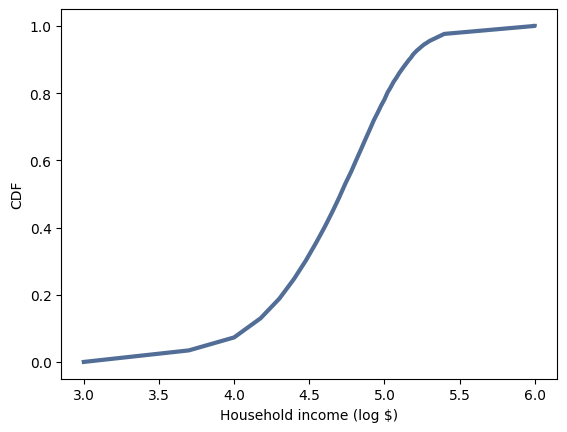

In [30]:
log_cdf = thinkstats2.Cdf(log_sample)
thinkplot.Cdf(log_cdf)
thinkplot.Config(xlabel='Household income (log $)',
               ylabel='CDF')

In [31]:
sample = np.power(10, log_sample)

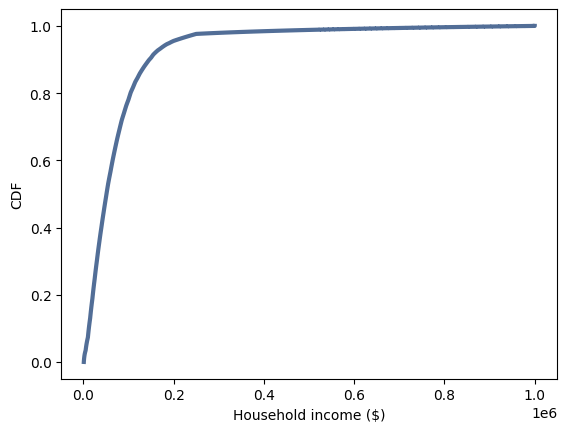

In [32]:
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Household income ($)',
               ylabel='CDF')

Compute the median, mean, skewness and Pearson’s skewness of the resulting sample. What fraction of households report a taxable income below the mean? How do the results depend on the assumed upper bound?

In [34]:
# Compute the median of the log sample and the sample
np.median(log_sample), np.median(sample)

(4.7094983556124745, 51226.93306562372)

In [35]:
# Compute the mean of the log sample and the sample
log_sample.mean(), sample.mean()

(4.657585735892018, 74278.7075311872)

In [36]:
# Compute the skewness of the log sample and the sample
thinkstats2.Skewness(log_sample), thinkstats2.Skewness(sample)

(-0.6413543665662108, 4.949920244429583)

In [37]:
# Compute the Pearson's skewness of the log sample and the sample
thinkstats2.PearsonMedianSkewness(log_sample), thinkstats2.PearsonMedianSkewness(sample)

(-0.3379202513383129, 0.7361258019141782)

What fraction of households reports a taxable infome below the mean? How do the results depend on the assumed upper bound?

In [39]:
# Compute the percentile rank of the log sample mean and sample mean
log_cdf.PercentileRank(log_sample.mean()), cdf.PercentileRank(sample.mean())

(45.06034722108805, 66.0005879566872)

All of this is based on an assumption that the highest income is one million dollars, but that's certainly not correct.  What happens to the skew if the upper bound is 10 million?

Without better information about the top of this distribution, we can't say much about the skewness of the distribution.

In [41]:
# Computing the statistics when the log_upper=7.0 i.e. the upper bound is 10 million
log_sample2 = InterpolateSample(income_df, log_upper=7.0)
sample2 = np.power(10, log_sample2)
cdf2 = thinkstats2.Cdf(sample2)
print(f'Sample median: {np.median(sample2)} \nSample mean: {sample2.mean()} \nSample skewness: {thinkstats2.Skewness(sample2)} \nSample Peason\'s'\
f' skewness: {thinkstats2.PearsonMedianSkewness(sample2)} \nSample percentile rank below mean: {cdf.PercentileRank(sample2.mean())}')

Sample median: 51226.93306562372 
Sample mean: 124267.39722164697 
Sample skewness: 11.603690267537793 
Sample Peason's skewness: 0.39156450927742087 
Sample percentile rank below mean: 85.65630665207664


When the assumed upper bound increases, the skewness increases, whereas the Pearson's skewness decreases.